In [1]:
# Covers tabular implementations of SERD and IDL and compares their effectivenes

In [45]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [2]:
# %store -r

In [3]:
#%store

In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

tile_map = [
        "F22222FF1",
        "U31122FU1",
        "UF1112FU1",
        "UFUU1SFU1",
        "UFFU1FFU3",
        "3222UFS1U",
        "UUU22F1FU",
        "FSSFS12SF",
        "FSFF121FF",
        "S1S2SFFSF",
        "FUUUFFSFU",
        "U3UUUFSFU",
        "FFFUUFUUU"
    ]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':4.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r * 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [5]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [6]:
# temperature = 1/(reward_normalizer)
# print(temperature)

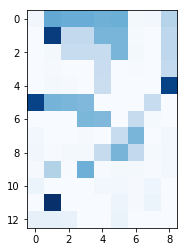

In [7]:
plt.imshow(reward_map, cmap="Blues")

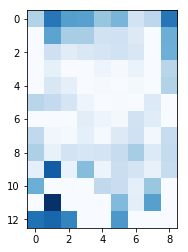

In [8]:
plt.imshow(texture_map, cmap="Blues")

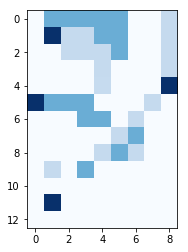

In [9]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [10]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

(array([ 3,  5,  7,  7,  7,  7,  8,  9,  9,  9,  9, 10, 11]), array([5, 6, 1, 2, 4, 7, 1, 0, 2, 4, 7, 6, 6]))


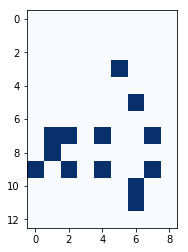

In [15]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [17]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [18]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [19]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [20]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [21]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [22]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


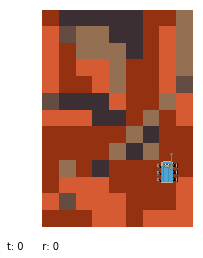

[154.78177694 147.32457278 148.57327988 155.22303342 152.1522923 ]
3
[0.38032003 0.00021955 0.0007653  0.59126811 0.02742701]
(7, 9) b'S'
(7, 8) b'F'


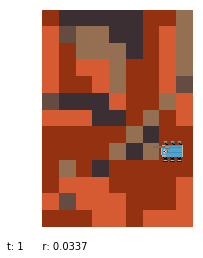

[159.19665294 152.88572317 152.35765945 158.4148463  156.0757659 ]
0
[0.66463549 0.00120721 0.00071194 0.30412296 0.0293224 ]
(7, 8) b'F'
(7, 7) b'S'


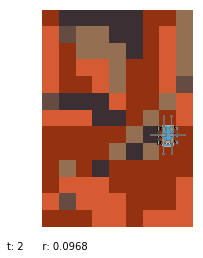

[162.29510013 156.05461948 150.51811495 159.37803811 159.0636962 ]
4
[0.91278272 0.00177894 0.00000701 0.04937459 0.03605674]
(7, 7) b'S'
(7, 7) b'S'


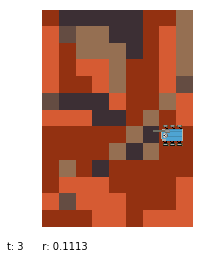

[162.29510013 156.05461948 150.51811495 159.37803811 159.0636962 ]
0
[0.91278272 0.00177894 0.00000701 0.04937459 0.03605674]
(7, 7) b'S'
(6, 7) b'2'


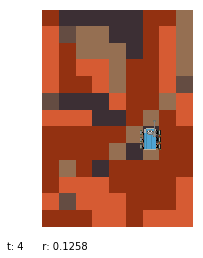

[161.04701269 160.03986945 159.83040372 164.52533539 163.33064953]
3
[0.02278988 0.00832425 0.00675112 0.73851354 0.22362121]
(6, 7) b'2'
(5, 7) b'1'


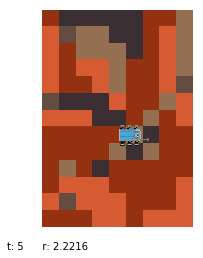

[157.25967221 159.16438941 162.77964627 161.7088901  160.5844574 ]
2
[0.00269761 0.01812119 0.67339943 0.23080714 0.07497463]
(5, 7) b'1'
(6, 7) b'2'


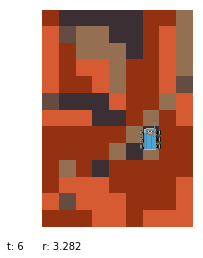

[161.04701269 160.03986945 159.83040372 164.52533539 163.33064953]
3
[0.02278988 0.00832425 0.00675112 0.73851354 0.22362121]
(6, 7) b'2'
(5, 7) b'1'


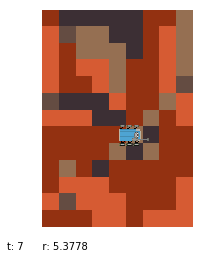

[157.25967221 159.16438941 162.77964627 161.7088901  160.5844574 ]
2
[0.00269761 0.01812119 0.67339943 0.23080714 0.07497463]
(5, 7) b'1'
(6, 7) b'2'


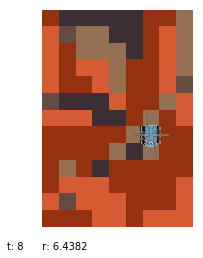

[161.04701269 160.03986945 159.83040372 164.52533539 163.33064953]
4
[0.02278988 0.00832425 0.00675112 0.73851354 0.22362121]
(6, 7) b'2'
(6, 7) b'2'


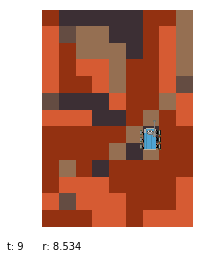

[161.04701269 160.03986945 159.83040372 164.52533539 163.33064953]
3
[0.02278988 0.00832425 0.00675112 0.73851354 0.22362121]
(6, 7) b'2'
(6, 6) b'1'


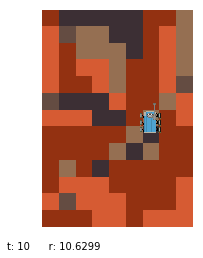

[163.0317922  162.90411816 161.48306661 167.96736093 165.70065003]
3
[0.00642391 0.00565394 0.0013652  0.89390175 0.09265519]
(6, 6) b'1'
(6, 5) b'S'


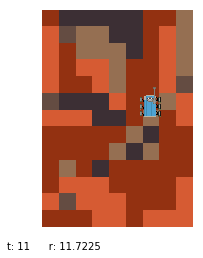

[167.59973534 164.20666125 154.07818316 173.12077605 169.65970299]
3
[0.00386437 0.00012986 0.00000001 0.965687   0.03031876]
(6, 5) b'S'
(6, 4) b'F'


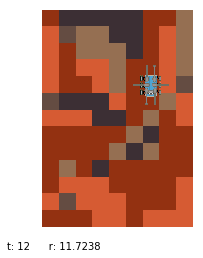

[180.44307798 153.86375523  35.36775328 165.29978474 176.84329353]
4
[0.97339717 0.         0.         0.00000026 0.02660257]
(6, 4) b'F'
(6, 4) b'F'


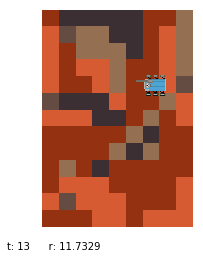

[180.44307798 153.86375523  35.36775328 165.29978474 176.84329353]
0
[0.97339717 0.         0.         0.00000026 0.02660257]
(6, 4) b'F'
(5, 4) b'F'


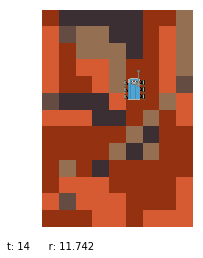

[166.19309733 167.36031664 177.02256173 185.05304995 181.35204212]
3
[0.00000001 0.00000002 0.00031745 0.97558688 0.02409565]
(5, 4) b'F'
(5, 3) b'S'


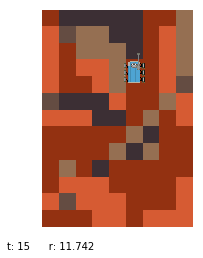

[185.09063396 181.91192708 184.77587071 192.64529016 188.79759287]
3
[0.00051226 0.00002133 0.00037393 0.97822805 0.02086442]
(5, 3) b'S'
(6, 3) b'F'


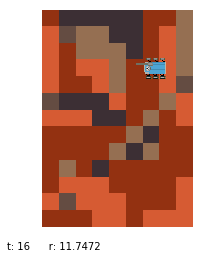

[187.67779866 160.35518274  36.64603336 170.52370799 183.95473988]
0
[0.97640995 0.         0.         0.00000003 0.02359002]
(6, 3) b'F'
(5, 3) b'S'


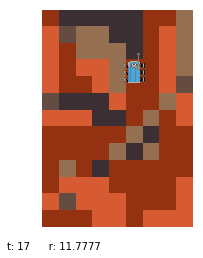

[185.09063396 181.91192708 184.77587071 192.64529016 188.79759287]
3
[0.00051226 0.00002133 0.00037393 0.97822805 0.02086442]
(5, 3) b'S'
(5, 2) b'2'


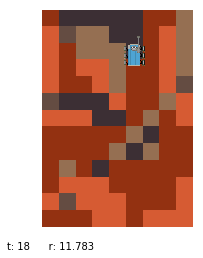

[196.20420717 189.69092838 190.26769466 196.61105646 194.76874597]
3
[0.36440385 0.00054063 0.00096247 0.5473629  0.08673015]
(5, 2) b'2'
(5, 1) b'2'


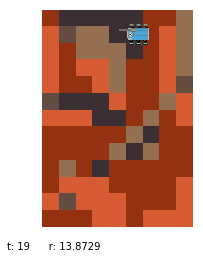

[199.33834001 195.00748297 192.03671896 194.71816722 197.44775297]
0
[0.85130658 0.01120002 0.00057416 0.0083863  0.12853295]
(5, 1) b'2'
(4, 1) b'2'


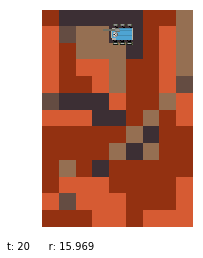

[202.4835337  197.69519406 197.47576665 198.67636305 200.52594411]
0
[0.84859289 0.00706561 0.00567354 0.01884804 0.11981992]
(4, 1) b'2'
(3, 1) b'1'


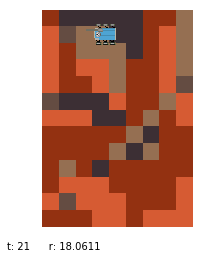

[206.67766426 200.84424627 200.5712365  202.09658804 203.70746179]
0
[0.93747656 0.00274498 0.00208916 0.00960338 0.04808591]
(3, 1) b'1'
(2, 1) b'1'


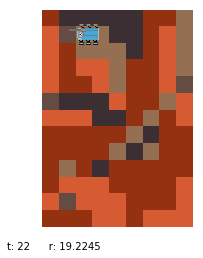

[211.21886395 204.03932964 203.81412172 206.08005897 208.1589788 ]
0
[0.94865125 0.00072289 0.00057712 0.00556355 0.04448518]
(2, 1) b'1'
(1, 1) b'3'


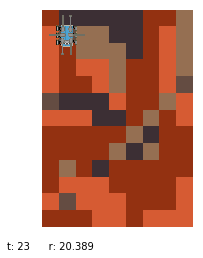

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


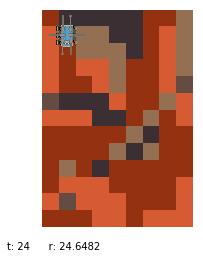

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


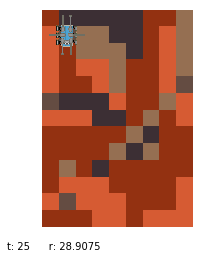

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


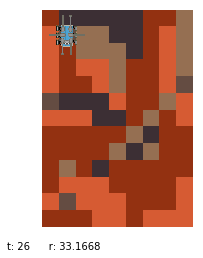

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


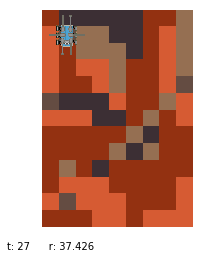

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


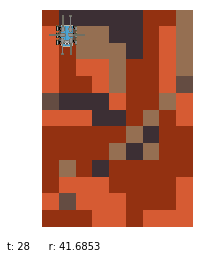

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


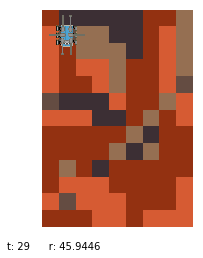

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


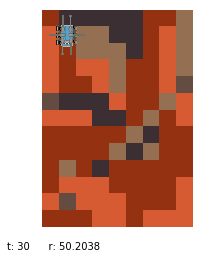

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


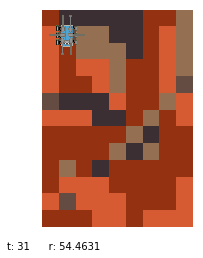

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


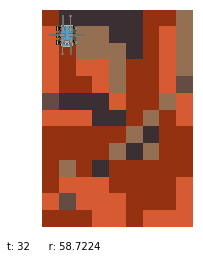

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


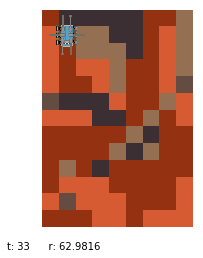

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


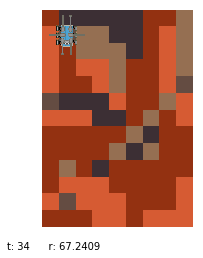

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


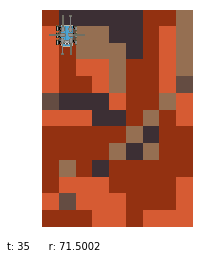

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


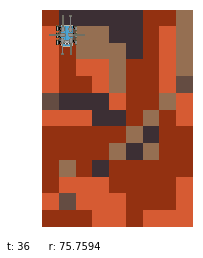

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


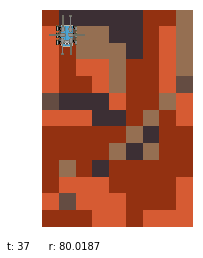

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


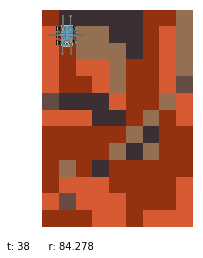

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


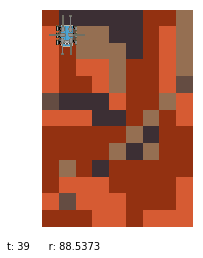

[ 40.2296826  176.88485332 206.75055665 186.53550851 212.96338957]
4
[0.         0.         0.00199955 0.         0.99800045]
(1, 1) b'3'
(1, 1) b'3'


In [23]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q),Qs=Q)


In [24]:
print(mdp.feature_map)

[[0.14971979 0.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.08818704 0.         0.         0.        ]
 [0.13141415 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.06091739 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.09723581 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         

# Inverse Dynamics Learning

In [25]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [26]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad)

In [27]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s])[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [28]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [29]:
def tabsoftq_TR_grad_iter(T_thetas, feat_map, R,  Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = feat_map.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    R_grad = T.dot(feat_map)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_t = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_t = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_t = R_t + gamma * V_t 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_t)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad), (GT - expGT_broad)

In [30]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, feat_map, R, Q, T=T,
        maxiter=tabsoftq_grad_iter_maxiter, verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(feat_map.shape[1]) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [31]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 80
demo_time_steps = 40

In [32]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays = set([])
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            if sas in unique_stays:
                demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [33]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [34]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [35]:
# Ensure bad areas have not been visited in exes
while len(set([adt[2] for adt in adt_obs])) > 1:
    demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
    sas_obs, adt_obs = vectorize_rollouts(demos)

In [36]:
# Clean training set to have greater density of interesting transitions
# print(len(sas_obs))
# demo_example_idxes = clean_demos(sas_obs)
# print(len(demo_example_idxes))
demo_example_idxes = list(range(len(sas_obs)))


In [37]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [39]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [40]:
maxiter = 300
learning_rate = 1

In [41]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [153]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ti_thetas))
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)
    idl_train_logs['true_trans_loss'].append(ttd)

250 -77.853012 -111.213588 -189.066601 0.374604
251 -77.969589 -110.985971 -188.955560 0.370334
252 -78.526376 -110.735342 -189.261719 0.367940
253 -79.395937 -110.771154 -190.167091 0.400854
254 -78.975579 -110.913761 -189.889341 0.378407
255 -77.994536 -110.971116 -188.965652 0.375003
256 -77.692698 -111.080200 -188.772898 0.364623
257 -78.036131 -110.958618 -188.994749 0.376060
258 -78.678240 -110.697496 -189.375736 0.373483
259 -78.208131 -110.422924 -188.631055 0.365078
260 -77.695003 -110.602673 -188.297675 0.351487
261 -77.660139 -110.797795 -188.457933 0.335120
262 -77.557287 -110.488573 -188.045859 0.353403
263 -78.232659 -110.402552 -188.635211 0.353271
264 -77.850805 -110.514233 -188.365038 0.350644
265 -78.909425 -110.495804 -189.405229 0.368517
266 -78.576997 -110.322662 -188.899659 0.348496
267 -78.971255 -110.226077 -189.197332 0.352622
268 -77.359876 -110.566937 -187.926813 0.324928
269 -77.547350 -110.311604 -187.858953 0.339793
270 -77.634575 -110.152159 -187.786734 0

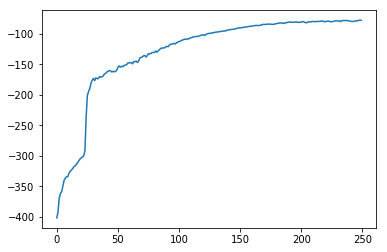

In [125]:
plt.plot(idl_train_logs['vp_lls'])

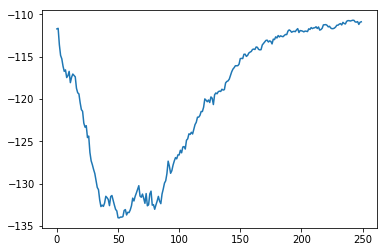

In [126]:
plt.plot(idl_train_logs['vt_lls'])

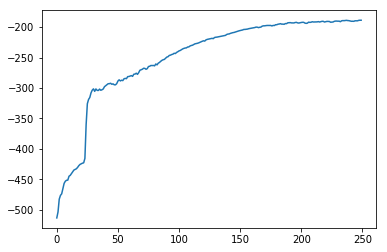

In [127]:
plt.plot(idl_train_logs['val_likelihoods'])

In [128]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[119.76368848 119.76368848 119.76368848 119.76368848 119.76368848]
 [114.45409862 114.45409862 114.45409862 114.45409862 114.45409862]
 [107.27605827 107.27605827 107.27605827 107.27605827 107.27605827]
 [108.06169558 108.06169558 108.06169558 108.06169558 108.06169558]
 [111.75340548 111.75340548 111.75340548 111.75340548 111.75340548]
 [117.73903764 117.73903764 117.73903764 117.73903764 117.73903764]
 [107.45904078 107.45904078 107.45904078 107.45904078 107.45904078]
 [112.16023758 112.16023758 112.16023758 112.16023758 112.16023758]
 [135.67553984 135.67553984 135.67553984 135.67553984 135.67553984]
 [115.29048065 115.29048065 115.29048065 115.29048065 115.29048065]
 [124.09326252 124.09326252 124.09326252 124.09326252 124.09326252]
 [121.21461079 121.21461079 121.21461079 121.21461079 121.21461079]
 [120.84621396 120.84621396 120.84621396 120.84621396 120.84621396]
 [ 93.17813959  93.17813959  93.17813959  93.17813959  93.17813959]
 [ 90.20556774  90.20556774  90.20556774  90.205

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


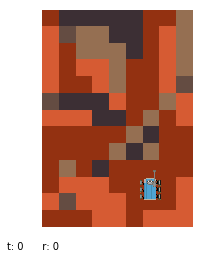

(6, 10) b'S'
(6, 9) b'F'


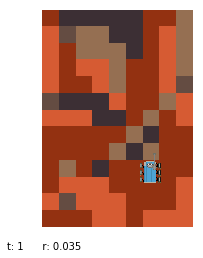

(6, 9) b'F'
(6, 8) b'1'


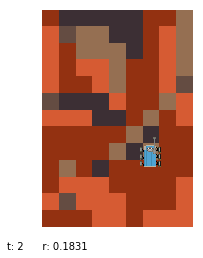

(6, 8) b'1'
(6, 7) b'2'


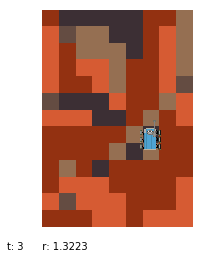

(6, 7) b'2'
(6, 6) b'1'


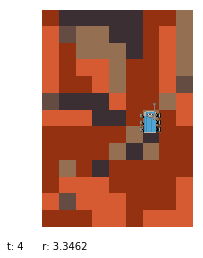

(6, 6) b'1'
(6, 5) b'S'


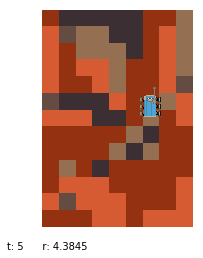

(6, 5) b'S'
(6, 4) b'F'


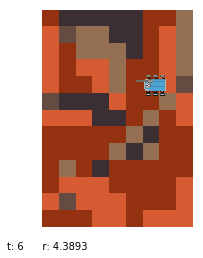

(6, 4) b'F'
(6, 3) b'F'


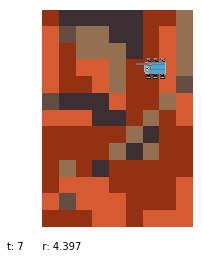

(6, 3) b'F'
(5, 3) b'S'


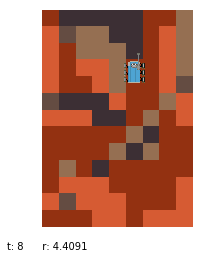

(5, 3) b'S'
(5, 2) b'2'


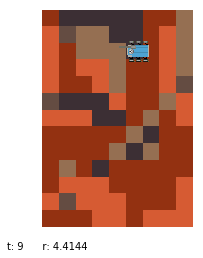

(5, 2) b'2'
(4, 2) b'1'


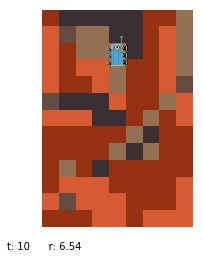

(4, 2) b'1'
(4, 1) b'2'


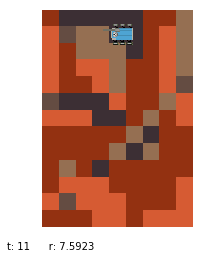

(4, 1) b'2'
(3, 1) b'1'


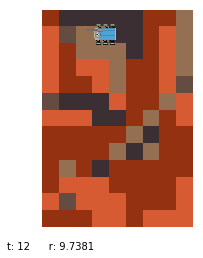

(3, 1) b'1'
(2, 1) b'1'


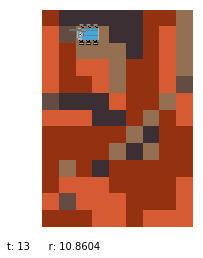

(2, 1) b'1'
(1, 1) b'3'


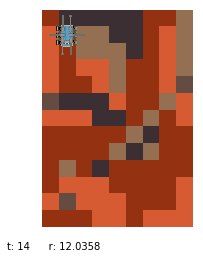

(1, 1) b'3'
(1, 1) b'3'


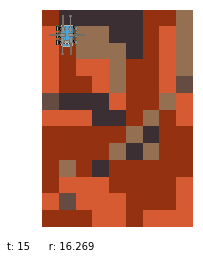

(1, 1) b'3'
(1, 1) b'3'


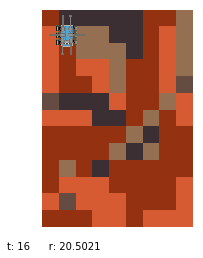

(1, 1) b'3'
(1, 1) b'3'


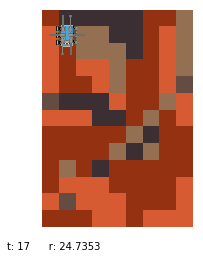

(1, 1) b'3'
(1, 1) b'3'


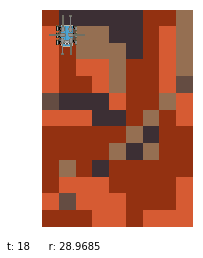

(1, 1) b'3'
(1, 1) b'3'


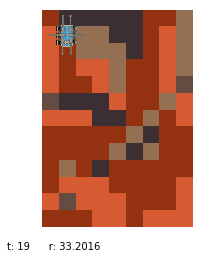

(1, 1) b'3'
(1, 1) b'3'


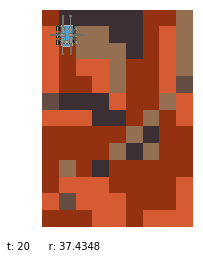

(1, 1) b'3'
(1, 1) b'3'


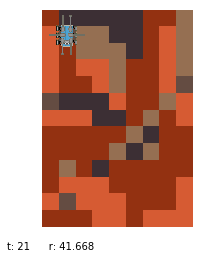

(1, 1) b'3'
(1, 1) b'3'


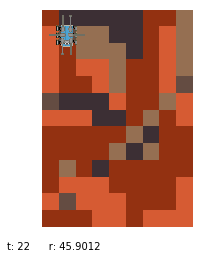

(1, 1) b'3'
(1, 1) b'3'


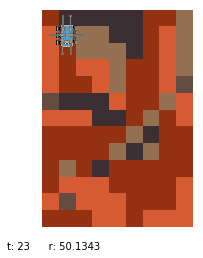

(1, 1) b'3'
(1, 1) b'3'


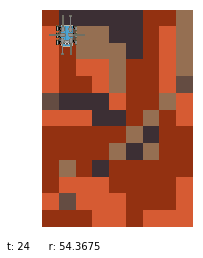

(1, 1) b'3'
(1, 1) b'3'


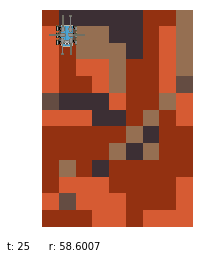

(1, 1) b'3'
(1, 1) b'3'


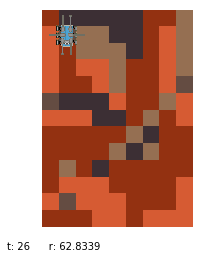

(1, 1) b'3'
(1, 1) b'3'


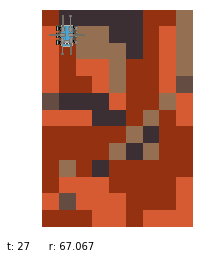

(1, 1) b'3'
(1, 1) b'3'


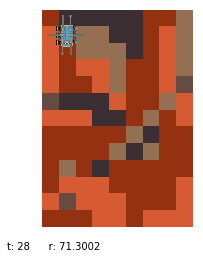

(1, 1) b'3'
(1, 1) b'3'


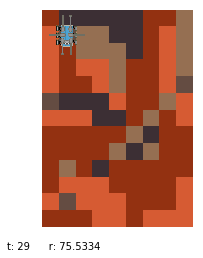

(1, 1) b'3'
(1, 1) b'3'


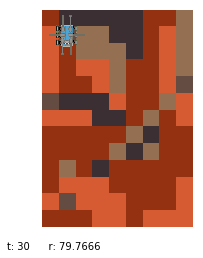

(1, 1) b'3'
(1, 1) b'3'


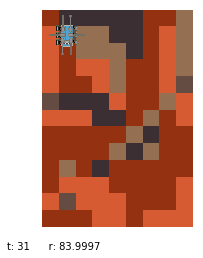

(1, 1) b'3'
(1, 1) b'3'


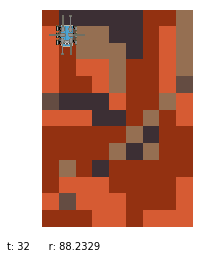

(1, 1) b'3'
(1, 1) b'3'


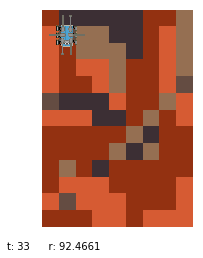

(1, 1) b'3'
(1, 1) b'3'


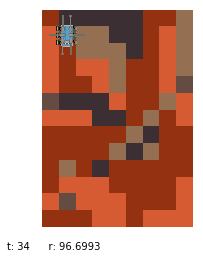

(1, 1) b'3'
(1, 1) b'3'


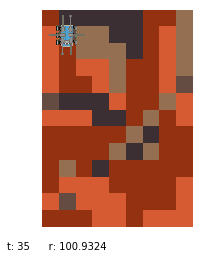

(1, 1) b'3'
(1, 1) b'3'


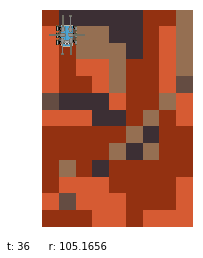

(1, 1) b'3'
(1, 1) b'3'


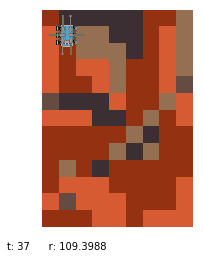

(1, 1) b'3'
(1, 1) b'3'


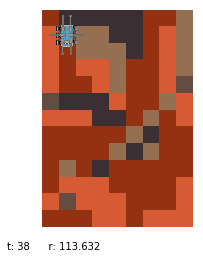

(1, 1) b'3'
(1, 1) b'3'


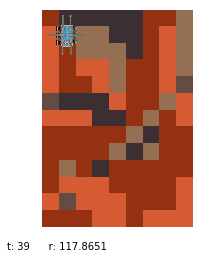

(1, 1) b'3'
(1, 1) b'3'
[[[0.76865975 0.01803119]
  [0.10381908 0.01407389]
  [0.00000002 0.012649  ]
  [0.12752114 0.00921394]
  [0.00000002 0.94603197]]

 [[0.16717205 0.01803119]
  [0.68361145 0.01407389]
  [0.1492161  0.012649  ]
  [0.0000002  0.00921394]
  [0.0000002  0.94603197]]

 [[0.00000006 0.01803119]
  [0.11317729 0.01407389]
  [0.7260038  0.012649  ]
  [0.16081879 0.00921394]
  [0.00000006 0.94603197]]

 [[0.13667036 0.01803119]
  [0.00000002 0.01407389]
  [0.09838936 0.012649  ]
  [0.76494025 0.00921394]
  [0.00000002 0.94603197]]

 [[0.00000001 0.01803119]
  [0.00000001 0.01407389]
  [0.00000001 0.012649  ]
  [0.00000001 0.00921394]
  [0.99999997 0.94603197]]]


In [129]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [130]:
tabsoftq_gen_pol_probs(Qi)[:,4]

array([0.02263359, 0.1246376 , 0.12614977, 0.14526031, 0.14065975,
       0.14791288, 0.02615205, 0.04285102, 0.09926273, 0.2       ,
       0.99436789, 0.04316268, 0.04693572, 0.12796591, 0.14191796,
       0.02181543, 0.2       , 0.13007558, 0.2       , 0.01965634,
       0.04722807, 0.05317969, 0.03969386, 0.08860655, 0.02179449,
       0.2       , 0.13936456, 0.2       , 0.03121616, 0.2       ,
       0.2       , 0.06334346, 0.02165522, 0.02400899, 0.2       ,
       0.08405921, 0.2       , 0.03042182, 0.01902039, 0.2       ,
       0.05125049, 0.02505692, 0.0266379 , 0.2       , 1.        ,
       1.        , 0.14665052, 0.18277996, 0.21903343, 0.2       ,
       0.0196164 , 0.03079504, 0.10242366, 0.2       , 0.2       ,
       0.2       , 0.2       , 0.23842967, 0.23773624, 0.0208373 ,
       0.08960114, 0.03861605, 0.2       , 0.06114804, 0.05738137,
       0.0518595 , 0.03561934, 0.03850651, 0.07429029, 0.21545548,
       0.03411185, 0.03340327, 0.05942471, 0.03527568, 0.05504

In [131]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.76865975 0.01803119]
  [0.10381908 0.01407389]
  [0.00000002 0.012649  ]
  [0.12752114 0.00921394]
  [0.00000002 0.94603197]]

 [[0.16717205 0.01803119]
  [0.68361145 0.01407389]
  [0.1492161  0.012649  ]
  [0.0000002  0.00921394]
  [0.0000002  0.94603197]]

 [[0.00000006 0.01803119]
  [0.11317729 0.01407389]
  [0.7260038  0.012649  ]
  [0.16081879 0.00921394]
  [0.00000006 0.94603197]]

 [[0.13667036 0.01803119]
  [0.00000002 0.01407389]
  [0.09838936 0.012649  ]
  [0.76494025 0.00921394]
  [0.00000002 0.94603197]]

 [[0.00000001 0.01803119]
  [0.00000001 0.01407389]
  [0.00000001 0.012649  ]
  [0.00000001 0.00921394]
  [0.99999997 0.94603197]]]


In [132]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[120.65987256 120.65987256 120.65987256 120.65987256 120.65987256]
 [114.86105967 114.86105967 114.86105967 114.86105967 114.86105967]
 [107.39961253 107.39961253 107.39961253 107.39961253 107.39961253]
 [108.04151793 108.04151793 108.04151793 108.04151793 108.04151793]
 [111.97351991 111.97351991 111.97351991 111.97351991 111.97351991]
 [118.06936618 118.06936618 118.06936618 118.06936618 118.06936618]
 [107.49742654 107.49742654 107.49742654 107.49742654 107.49742654]
 [112.18138877 112.18138877 112.18138877 112.18138877 112.18138877]
 [135.55193231 135.55193231 135.55193231 135.55193231 135.55193231]
 [115.11588077 115.11588077 115.11588077 115.11588077 115.11588077]
 [124.29301223 124.29301223 124.29301223 124.29301223 124.29301223]
 [121.41941091 121.41941091 121.41941091 121.41941091 121.41941091]
 [120.98076099 120.98076099 120.98076099 120.980760

-189.06660061485496

In [133]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[206.86530091 206.86530091 206.86530091 206.86530091 206.86530091]
 [197.2101437  197.2101437  197.2101437  197.2101437  197.2101437 ]
 [200.76825246 200.76825246 200.76825246 200.76825246 200.76825246]
 [193.00840473 193.00840473 193.00840473 193.00840473 193.00840473]
 [198.68478496 198.68478496 198.68478496 198.68478496 198.68478496]
 [199.06492432 199.06492432 199.06492432 199.06492432 199.06492432]
 [196.36235889 196.36235889 196.36235889 196.36235889 196.36235889]
 [191.2721601  191.2721601  191.2721601  191.2721601  191.2721601 ]
 [201.34422406 201.34422406 201.34422406 201.34422406 201.34422406]
 [193.23737987 193.23737987 193.23737987 193.23737987 193.23737987]
 [191.11983865 191.11983865 191.11983865 191.11983865 191.11983865]
 [190.55851873 190.55851873 190.55851873 190.55851873 190.55851873]
 [194.41489271 194.41489271 194.41489271 194.414892

-513.4479210478701

In [134]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

[9, 16, 18, 25, 27, 29, 30, 34, 36, 39, 43, 49, 53, 54, 55, 56, 62, 91, 92, 93, 98, 99, 101, 102, 103, 107, 111, 112, 114, 115, 116]
[[0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.00788625]
 [0.00788625 0.00788625 0.00788625 0.00788625 0.0078862

-184.8244991057407

In [135]:
true_trans_loss(softmax(Ti_thetas))

0.37460378738996886

In [180]:
softmax(Ti_thetas)

array([[[0.77435286, 0.0137429 ],
        [0.10465391, 0.0109317 ],
        [0.00000002, 0.00985696],
        [0.12099319, 0.00712063],
        [0.00000002, 0.95834781]],

       [[0.14954778, 0.0137429 ],
        [0.70780566, 0.0109317 ],
        [0.14264618, 0.00985696],
        [0.00000019, 0.00712063],
        [0.00000019, 0.95834781]],

       [[0.00000006, 0.0137429 ],
        [0.11976236, 0.0109317 ],
        [0.75574197, 0.00985696],
        [0.12449556, 0.00712063],
        [0.00000006, 0.95834781]],

       [[0.12627922, 0.0137429 ],
        [0.00000002, 0.0109317 ],
        [0.09789859, 0.00985696],
        [0.77582216, 0.00712063],
        [0.00000002, 0.95834781]],

       [[0.00000001, 0.0137429 ],
        [0.00000001, 0.0109317 ],
        [0.00000001, 0.00985696],
        [0.00000001, 0.00712063],
        [0.99999997, 0.95834781]]])

In [136]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

2.2292293525117874

In [137]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

array([[[0.8130671 , 0.2       ],
        [0.09255899, 0.2       ],
        [0.00000002, 0.2       ],
        [0.09437388, 0.2       ],
        [0.00000002, 0.2       ]],

       [[0.09375008, 0.2       ],
        [0.79687453, 0.2       ],
        [0.10937507, 0.2       ],
        [0.00000016, 0.2       ],
        [0.00000016, 0.2       ]],

       [[0.00000005, 0.2       ],
        [0.11926607, 0.2       ],
        [0.81651362, 0.2       ],
        [0.06422021, 0.2       ],
        [0.00000005, 0.2       ]],

       [[0.09014085, 0.2       ],
        [0.00000001, 0.2       ],
        [0.09295775, 0.2       ],
        [0.81690137, 0.2       ],
        [0.00000001, 0.2       ]],

       [[0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.00000001, 0.2       ],
        [0.99999997, 0.2       ]]])

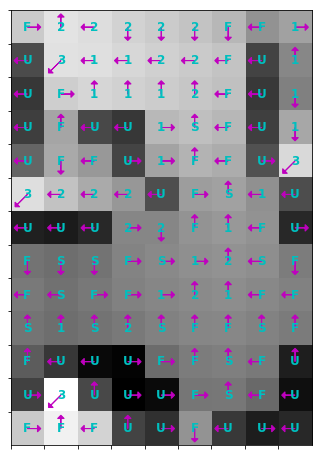

In [138]:
plot_values(mdp, Qi)

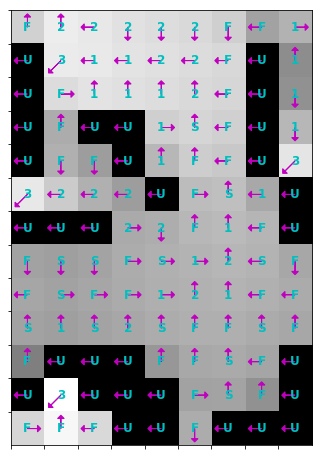

In [139]:
plot_values(mdp, exQs)

## SERD only

In [140]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [141]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [150]:
maxiter = 300
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [151]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    Rs = feats.dot(Rs_thetas)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ts_thetas))
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

#     print(dT_trans)
#     print(dT_pol)
#     print(softmax(Ts_thetas))
#     print(dR_pol * r_learning_rate(t))
#     print(Rs_thetas)
#     if prevQs is not None:
#         print("Q_diff")
#         print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)
    serd_train_logs['true_trans_loss'].append(ttd)

254 -84.511690 -111.515999 -196.027689 0.342564
255 -84.598895 -111.632198 -196.231093 0.348486
256 -84.689724 -111.855203 -196.544928 0.351662
257 -84.757533 -111.837281 -196.594814 0.355535
258 -84.662085 -111.763940 -196.426024 0.349664
259 -84.735217 -111.907794 -196.643011 0.339046
260 -84.739075 -111.879159 -196.618234 0.333285
261 -84.893335 -112.297995 -197.191330 0.342900
262 -84.715004 -112.019327 -196.734331 0.333356
263 -84.504959 -111.750705 -196.255664 0.332319
264 -84.498462 -111.974922 -196.473383 0.324617
265 -84.491640 -111.991438 -196.483078 0.316191
266 -84.331177 -111.798466 -196.129643 0.301039
267 -84.219951 -111.821748 -196.041699 0.297333
268 -84.300931 -111.795246 -196.096178 0.293787
269 -84.370096 -111.999066 -196.369162 0.294922
270 -84.269348 -111.748030 -196.017378 0.290419
271 -84.214790 -112.017220 -196.232011 0.293128
272 -84.276675 -112.602916 -196.879591 0.306505
273 -84.143652 -112.472580 -196.616233 0.298555
274 -84.183204 -112.514876 -196.698079 0

In [181]:
print(softmax(Ts_thetas))

[[[0.80647284 0.00414488]
  [0.1178493  0.00361448]
  [0.00000002 0.00276931]
  [0.07567782 0.00216312]
  [0.00000002 0.98730821]]

 [[0.18036477 0.00414488]
  [0.66881969 0.00361448]
  [0.15081513 0.00276931]
  [0.0000002  0.00216312]
  [0.0000002  0.98730821]]

 [[0.00000005 0.00414488]
  [0.13383067 0.00361448]
  [0.78970602 0.00276931]
  [0.07646321 0.00216312]
  [0.00000005 0.98730821]]

 [[0.09551918 0.00414488]
  [0.00000001 0.00361448]
  [0.07287603 0.00276931]
  [0.83160476 0.00216312]
  [0.00000001 0.98730821]]

 [[0.00000001 0.00414488]
  [0.00000001 0.00361448]
  [0.00000001 0.00276931]
  [0.00000001 0.00216312]
  [0.99999997 0.98730821]]]


In [154]:
print(Rs_thetas)

[0.91629397 0.50675721 0.92581826 3.04996139]


In [179]:
true_trans_loss(softmax(Ts_thetas))

0.2922101073092341

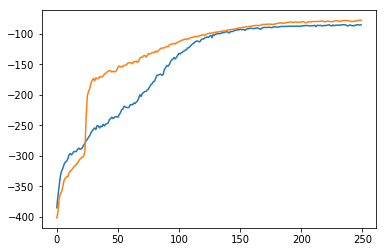

In [155]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

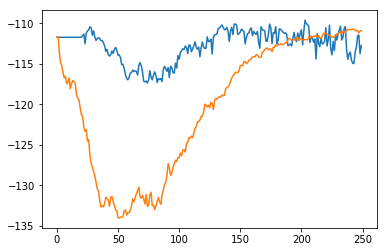

In [156]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

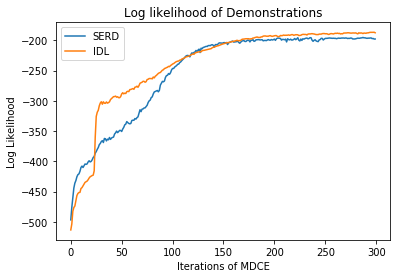

In [159]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

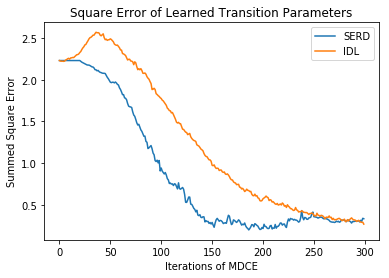

In [160]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [161]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [162]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [163]:
print(demo_stats(mdp, SERD_demos))

{'mean episode reward': 92.50814589728367, 'sd episode reward': 31.605685062495674, 'mean discounted episode reward': 56.1767485790304, 'sd discounted episode reward': 20.67445821182342}


In [164]:
print(demo_stats(mdp, IDL_demos))

{'mean episode reward': 95.38831799317883, 'sd episode reward': 32.16785006105494, 'mean discounted episode reward': 58.24606416842388, 'sd discounted episode reward': 20.76648098719456}


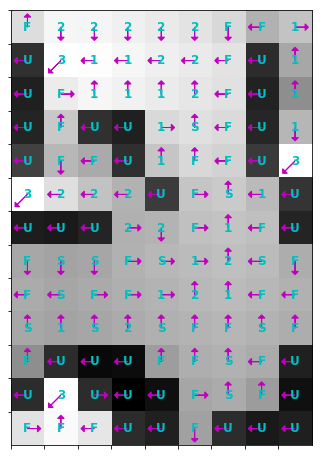

In [165]:
plot_values(mdp, Qs)

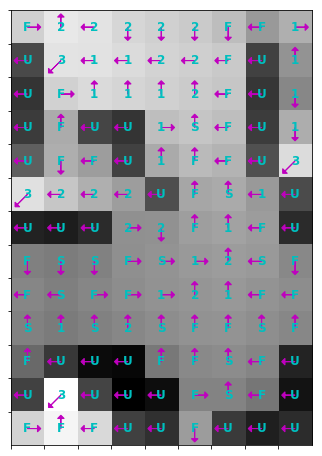

In [166]:
plot_values(mdp, Qi)

In [167]:
print(reward_map[5][0], Qi[2], Q[2])

4.188464525236584 [211.02717084 207.32565368 201.85513644 202.38428539 209.13873203] [209.53249135 207.12763517 200.72300635 194.76212142 207.67394623]


### Transfer

In [42]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

[[2.36802745 0.22811527 0.15740873 0.14313257 0.0744019  0.07004249
  0.08774505 0.10865051 1.28916666]
 [0.12314846 0.13588639 0.08958903 0.05879917 0.06820007 0.05091836
  0.04934566 0.12247491 0.13084715]
 [0.14165519 0.11470708 0.0739959  0.07029743 0.         0.02732301
  0.04078025 0.11827726 0.0873808 ]
 [0.10802227 0.075914   0.04366223 0.         0.         0.
  0.01701102 0.00844019 0.0628232 ]
 [0.13689537 0.05658927 0.         0.         4.0000755  0.
  0.         0.05862111 0.07095021]
 [0.1372962  0.01138655 0.03178813 0.         0.         0.
  0.01934275 0.00596903 0.05027252]
 [0.1153154  0.01941586 0.0173103  0.02047026 0.         0.01234996
  0.03094084 0.00529459 0.08205672]
 [0.12089068 0.13566244 0.10091746 0.00889653 0.00715643 0.00723065
  0.04469045 0.08633329 0.08133085]
 [1.25065432 0.19015473 0.1000867  0.07474081 0.07053076 0.09556835
  0.06344445 0.0804466  2.24535073]]
[[0.36802745 0.22811527 0.15740873 0.14313257 0.0744019  0.07004249
  0.08774505 0.1086

In [43]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [170]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [171]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [172]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


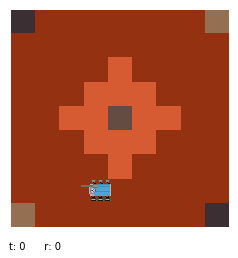

[107.45843112 108.06474107 103.54236071  99.54173532 105.91322064]
0
[0.32602989 0.59782557 0.00649426 0.00011887 0.06953141]
(3, 7) b'S'
(2, 7) b'F'


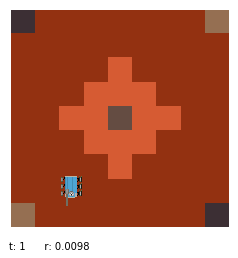

[110.98201128 110.96674717 106.52540536 106.06564697 108.83527916]
1
[0.47155473 0.46441152 0.00547082 0.00345448 0.05510845]
(2, 7) b'F'
(2, 8) b'F'


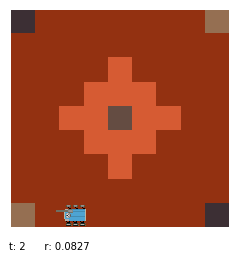

[113.98265789 112.85272162 109.32157494 109.59406387 111.81333787]
0
[0.68531476 0.22139357 0.00648048 0.00851036 0.07830083]
(2, 8) b'F'
(1, 8) b'F'


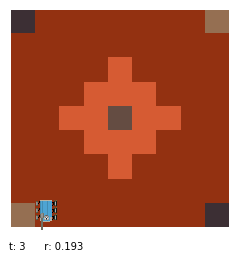

[117.12203844 116.11652733 112.3800128  112.5726481  114.88680825]
1
[0.67018751 0.24519319 0.00584468 0.00708633 0.07168829]
(1, 8) b'F'
(1, 0) b'F'


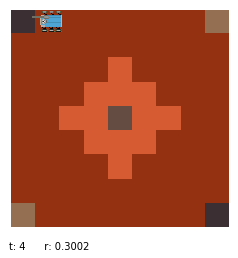

[118.81452767 114.6688394  113.51579063 115.38489301 116.57946999]
0
[0.86190909 0.01364621 0.00430774 0.0279248  0.09221217]
(1, 0) b'F'
(1, 8) b'F'


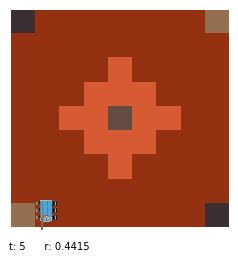

[117.12203844 116.11652733 112.3800128  112.5726481  114.88680825]
1
[0.67018751 0.24519319 0.00584468 0.00708633 0.07168829]
(1, 8) b'F'
(1, 0) b'F'


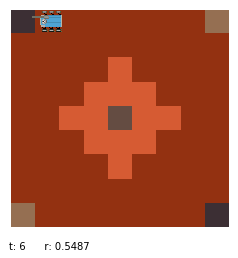

[118.81452767 114.6688394  113.51579063 115.38489301 116.57946999]
0
[0.86190909 0.01364621 0.00430774 0.0279248  0.09221217]
(1, 0) b'F'
(0, 0) b'2'


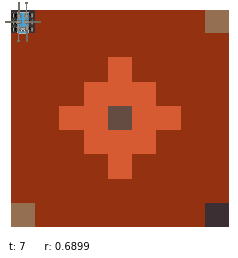

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


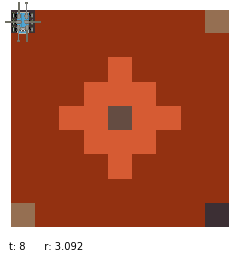

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


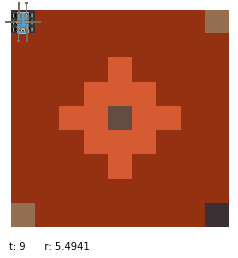

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


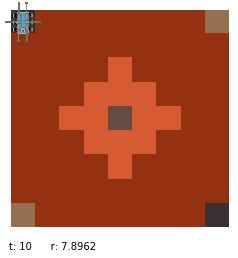

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


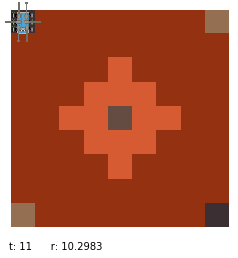

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


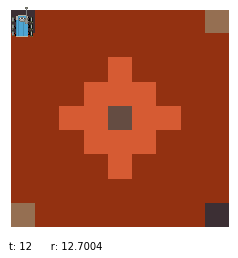

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
3
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(8, 0) b'1'


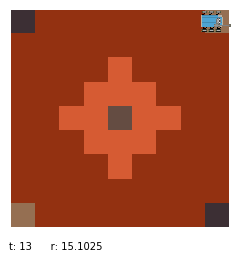

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
2
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(0, 0) b'2'


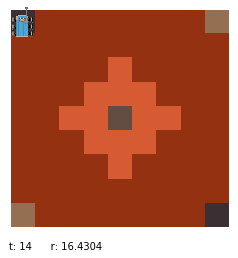

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
3
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 8) b'1'


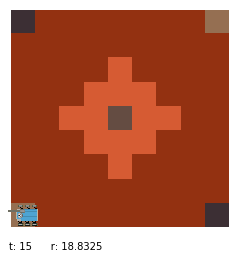

[118.13475812 119.11220333 115.45753889 114.99821646 118.03003707]
0
[0.21411349 0.56904039 0.01472118 0.00929954 0.19282541]
(0, 8) b'1'
(8, 8) b'2'


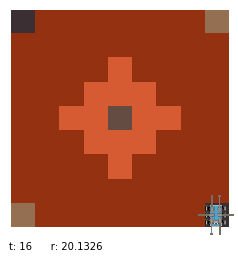

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
4
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 8) b'2'


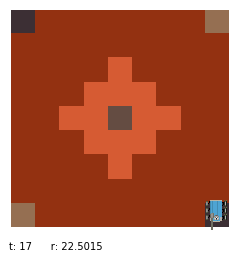

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
1
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 0) b'1'


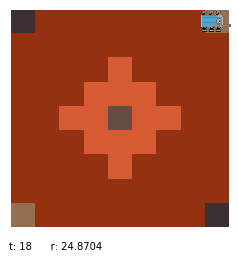

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
2
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(0, 0) b'2'


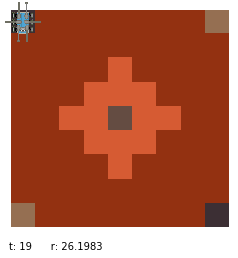

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


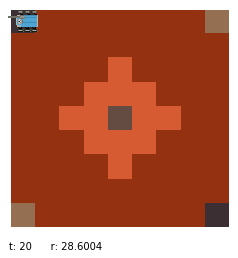

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
0
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(8, 0) b'1'


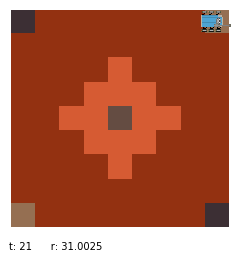

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
2
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(0, 0) b'2'


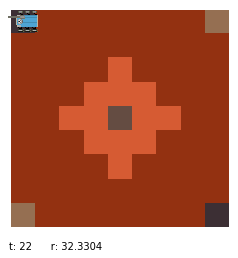

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
0
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(8, 0) b'1'


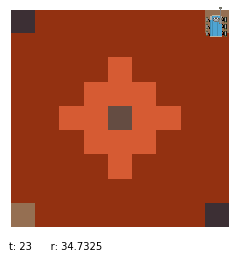

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
3
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(8, 8) b'2'


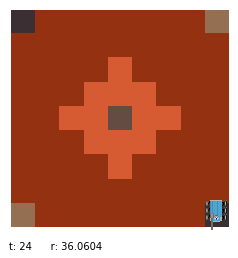

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
1
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 0) b'1'


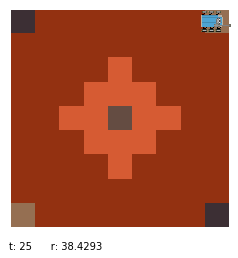

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
2
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(0, 0) b'2'


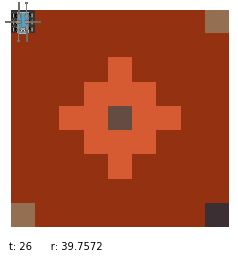

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


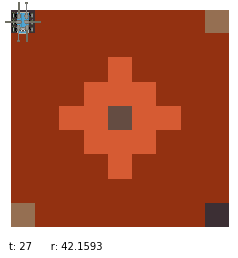

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


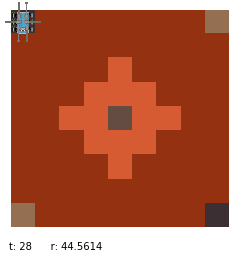

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


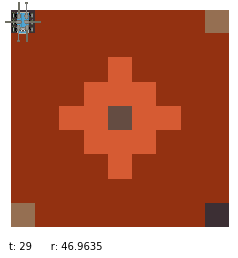

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


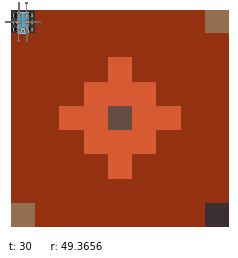

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


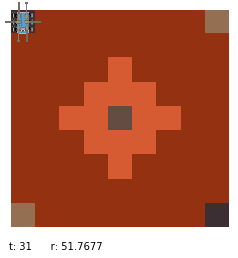

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
4
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 0) b'2'


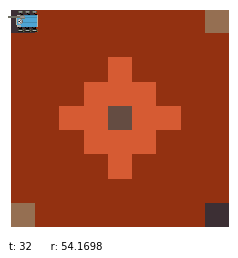

[118.04557619 116.86524003 116.76642054 117.91441256 120.10493872]
0
[0.09705448 0.02981275 0.02700756 0.08512398 0.76100123]
(0, 0) b'2'
(0, 8) b'1'


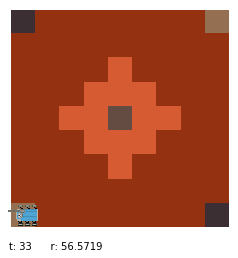

[118.13475812 119.11220333 115.45753889 114.99821646 118.03003707]
0
[0.21411349 0.56904039 0.01472118 0.00929954 0.19282541]
(0, 8) b'1'
(8, 8) b'2'


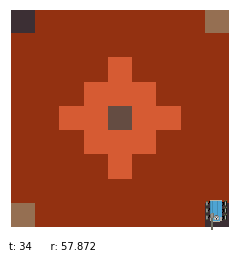

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
1
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 0) b'1'


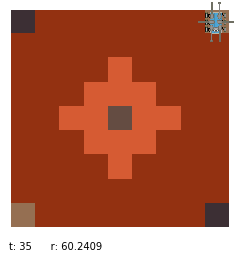

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
4
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(8, 0) b'1'


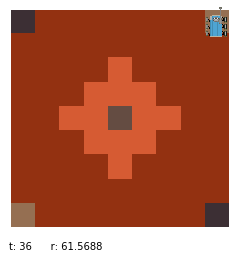

[115.329799   115.77004208 119.29699202 118.15608171 118.23897023]
3
[0.01103591 0.0171397  0.58309351 0.18631471 0.20241616]
(8, 0) b'1'
(8, 8) b'2'


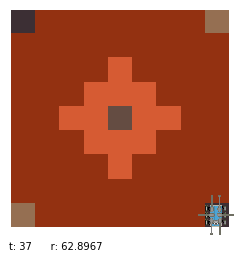

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
4
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 8) b'2'


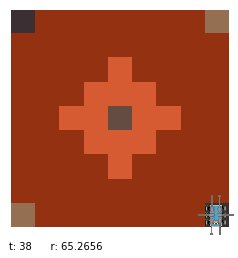

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
4
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 8) b'2'


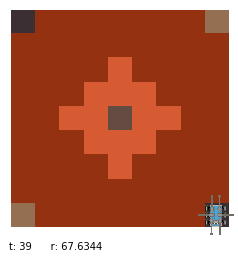

[115.25286344 117.71562652 117.63802947 115.04085735 118.444014  ]
4
[0.02052401 0.24089441 0.22290856 0.0166031  0.49906991]
(8, 8) b'2'
(8, 8) b'2'


In [173]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [174]:
print(demo_stats(mdp, IDL_trans_demos))

{'mean episode reward': 66.22070275346064, 'sd episode reward': 9.770474207865503, 'mean discounted episode reward': 43.51456731476139, 'sd discounted episode reward': 6.923698530577348}


In [175]:
print(demo_stats(mdp, SERD_trans_demos))

{'mean episode reward': 33.013895021263636, 'sd episode reward': 12.650532991033536, 'mean discounted episode reward': 21.22016309562749, 'sd discounted episode reward': 8.513612711927768}


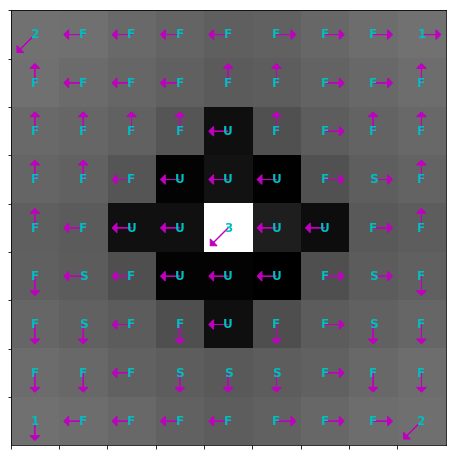

In [176]:
plot_values(mdp, Qit)

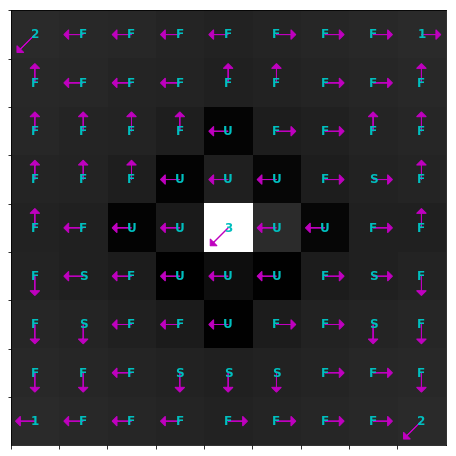

In [177]:
plot_values(mdp, Qst)

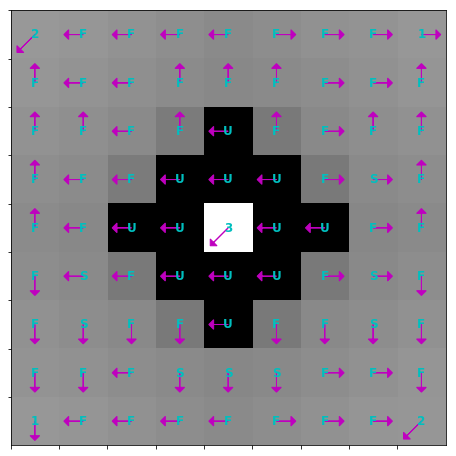

In [178]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)